# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [265]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [266]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [267]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-10 09:00:00+09:00,48510.718750,48510.718750,48286.808594,48392.601562,0,0.0,0.0
2025-10-10 09:15:00+09:00,48381.109375,48441.390625,48337.289062,48362.511719,0,0.0,0.0
2025-10-10 09:30:00+09:00,48354.699219,48438.269531,48269.378906,48292.128906,0,0.0,0.0
2025-10-10 09:45:00+09:00,48288.750000,48378.488281,48213.351562,48370.468750,0,0.0,0.0
2025-10-10 10:00:00+09:00,48373.378906,48382.460938,48212.578125,48245.441406,0,0.0,0.0
2025-10-10 10:15:00+09:00,48241.128906,48297.839844,48174.500000,48261.308594,0,0.0,0.0
2025-10-10 10:30:00+09:00,48263.710938,48315.378906,48176.410156,48234.000000,0,0.0,0.0
2025-10-10 10:45:00+09:00,48232.160156,48272.101562,48200.519531,48233.921875,0,0.0,0.0
2025-10-10 11:00:00+09:00,48233.500000,48234.109375,48104.140625,48105.429688,0,0.0,0.0


## 前日終値の取得

In [268]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-03 00:00:00+09:00    45769.500000
2025-10-06 00:00:00+09:00    47944.761719
2025-10-07 00:00:00+09:00    47950.878906
2025-10-08 00:00:00+09:00    47734.988281
2025-10-09 00:00:00+09:00    48580.441406
2025-10-10 00:00:00+09:00    48125.121094
Name: Close, dtype: float64


Date
2025-10-09 00:00:00+09:00    48580.441406
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [269]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-69.72


## ローソク足チャート（小さいサイズ）

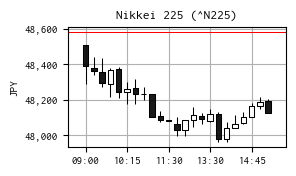

In [270]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [271]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [272]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-09 08:00:00+09:00,152.522995,152.552002,152.457993,152.479004,0,0.0,0.0
2025-10-09 08:15:00+09:00,152.475006,152.720993,152.466003,152.679993,0,0.0,0.0
2025-10-09 08:30:00+09:00,152.675995,152.681000,152.597000,152.634003,0,0.0,0.0
2025-10-09 08:45:00+09:00,152.634003,152.712006,152.539001,152.709000,0,0.0,0.0
2025-10-09 09:00:00+09:00,152.707993,152.737000,152.487000,152.604004,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-10 14:30:00+09:00,152.755005,152.832993,152.746002,152.764008,0,0.0,0.0
2025-10-10 14:45:00+09:00,152.759003,152.848999,152.746994,152.824997,0,0.0,0.0
2025-10-10 15:00:00+09:00,152.832001,152.899002,152.813995,152.867996,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [273]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-10 09:00:00+09:00,316.752992,316.752992,315.290960,315.981740
2025-10-10 09:15:00+09:00,316.059396,316.453195,315.773131,315.937903
2025-10-10 09:30:00+09:00,315.857994,316.403885,315.300673,315.449279
2025-10-10 09:45:00+09:00,315.713848,316.300560,315.220890,316.248128
2025-10-10 10:00:00+09:00,316.372667,316.432066,315.320994,315.535928
2025-10-10 10:15:00+09:00,315.464372,315.835223,315.028664,315.596334
2025-10-10 10:30:00+09:00,315.568716,315.906543,314.997906,315.374453
2025-10-10 10:45:00+09:00,315.209900,315.470928,315.003121,315.221414
2025-10-10 11:00:00+09:00,315.344379,315.348363,314.498644,314.507071


### 前日の終値のドル円レートから、前日の終値のドル換算

In [274]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-09 15:15:00+09:00


np.float64(152.99200439453125)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

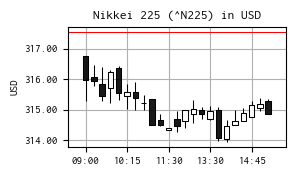

In [275]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()